# Проект 6. Оптимизация маркетинговых затрат для Яндекс.Афиши

## 1. Предобработка данных

Для начала посмотрим на имеющиеся датасеты, приведем данные к нужному типу, создадим необходимые дополнительные переменные.  
Импортируем библиотеки, которые могут понадобиться.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats as st
import seaborn as sns

Прочитаем датасеты.

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
visits.head()

,Uid,Device,End Ts,Source Id,Start Ts
0,16879256277535980062,touch,20.12.2017 17:38,4,20.12.2017 17:20
1,104060357244891740,desktop,19.02.2018 17:21,2,19.02.2018 16:53
2,7459035603376831527,touch,01.07.2017 1:54,5,01.07.2017 1:54
3,16174680259334210214,desktop,20.05.2018 11:23,9,20.05.2018 10:59
4,9969694820036681168,desktop,27.12.2017 14:06,3,27.12.2017 14:06


In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358532 entries, 0 to 358531
Data columns (total 5 columns):
Uid          358532 non-null uint64
Device       358532 non-null object
End Ts       358532 non-null object
Source Id    358532 non-null int64
Start Ts     358532 non-null object
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Пропущенных значений нет, что радует )  
Но необходимо привести названия столбцов к более оптимальному виду и поменять тип столбцов с датами.

In [4]:
visits.set_axis(['uid','device','end_ts','source_id','start_ts'],axis = 'columns',inplace = True)
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%d.%m.%Y %H:%M')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%d.%m.%Y %H:%M')
visits.head()

,uid,device,end_ts,source_id,start_ts
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00


Проверим список значений и их количество в столбцах device и source_id.

In [5]:
visits['device'].value_counts()

desktop    261913
touch       96619
Name: device, dtype: int64

In [6]:
visits['source_id'].value_counts()

4     101653
3      85448
5      66711
2      47473
1      33943
9      13257
10     10005
7         36
6          6
Name: source_id, dtype: int64

Есть два источника с небольшим количеством вариантов - возможно, это ошибка.

Проверим диапазон дат для столбца start_ts.

In [7]:
visits['start_ts'].describe()

count                  358532
unique                 223977
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

Отлично! Первое число - 1 июня 2017, последнее - 31 мая 2018.  
Значит, ошибок при последующем анализе не будет.

In [8]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


В датафрейме с заказами также имеет смысл переименовать столбцы и привести столбец с датами к нужному формату.

In [10]:
orders.set_axis(['buy_ts','revenue','uid'],axis = 'columns',inplace = True)
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Проверим для этого датасета диапазон дат.

In [11]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

А вот здесь печалька... Надо что-то делать с июньской покупкой, она может "испортить" весь анализ.  
Присоединим ее к майским!

In [12]:
def date_change(row):
    buy_ts = row['buy_ts']
    if buy_ts > pd.Timestamp('2018-06-01T00'):
        return buy_ts - pd.to_timedelta(1, unit='d')
    else:
        return buy_ts
orders['buy_ts'] = orders.apply(date_change, axis=1)
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-05-31 23:56:00
Name: buy_ts, dtype: object

Ура, проблема решена!

In [13]:
costs = pd.read_csv('/datasets/costs.csv')
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [14]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


В датафрейме с данными о затратах на маркетинг также стоит привести к нужному типу столбец dt.

In [15]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Проверим список значений в столбце source_id.

In [16]:
costs['source_id'].value_counts()

5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64

Вариантов 6 и 7 здесь нет... Вероятно, это бесплатные источники...

## 2. Анализ данных и подготовка отчетов

### Метрики продукта

Начнем с построения основных метрик продукта.  
Нам необходимо понять:  
    •	Сколько людей пользуются в день, неделю, месяц?  
    •	Сколько сессий в день?  
    •	Сколько длится одна сессия?  
    •	Как часто люди возвращаются?  

Для анализа нам понадобится датасет с данными о посещениях сайта.  
Создадим в нем столбцы с месяцем, днем, неделей визита.

In [17]:
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')
visits['visit_day'] = visits['start_ts'].astype('datetime64[D]')
visits['visit_week'] = pd.to_datetime(visits['start_ts'].dt.date) - pd.to_timedelta(visits['start_ts'].dt.dayofweek, unit='d')
visits.head()

,uid,device,end_ts,source_id,start_ts,visit_month,visit_day,visit_week
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,2017-12-01,2017-12-20,2017-12-18
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,2018-02-01,2018-02-19,2018-02-19
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,2017-07-01,2017-07-01,2017-06-26
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,2018-05-01,2018-05-20,2018-05-14
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,2017-12-01,2017-12-27,2017-12-25


Начнем с анализа количества пользователей по месяцам.

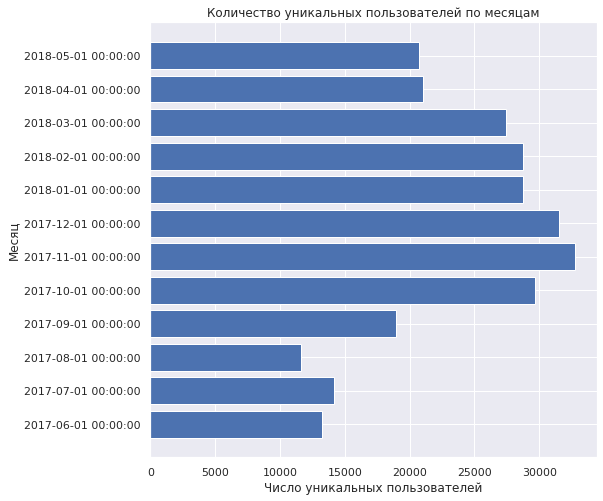

In [18]:
visits_monthly_number = visits.groupby('visit_month').agg({'uid':'nunique'}).reset_index()
index = np.arange(len(visits_monthly_number))
sns.set(rc={'figure.figsize':(8,8)})
plt.barh(index, visits_monthly_number.uid)
plt.ylabel('Месяц')
plt.xlabel('Число уникальных пользователей')
plt.yticks(index, visits_monthly_number.visit_month)
plt.title('Количество уникальных пользователей по месяцам')
plt.show()

Видно, что к Яндекс.Афише чаще обращаются в холодное время года: летом люди либо уезжают в отпуска, либо больше проводят времени на природе.

In [19]:
visits_monthly_number.mean()

uid    23228.416667
dtype: float64

Среднемесячное число уникальных пользователей - более 23 тысяч.

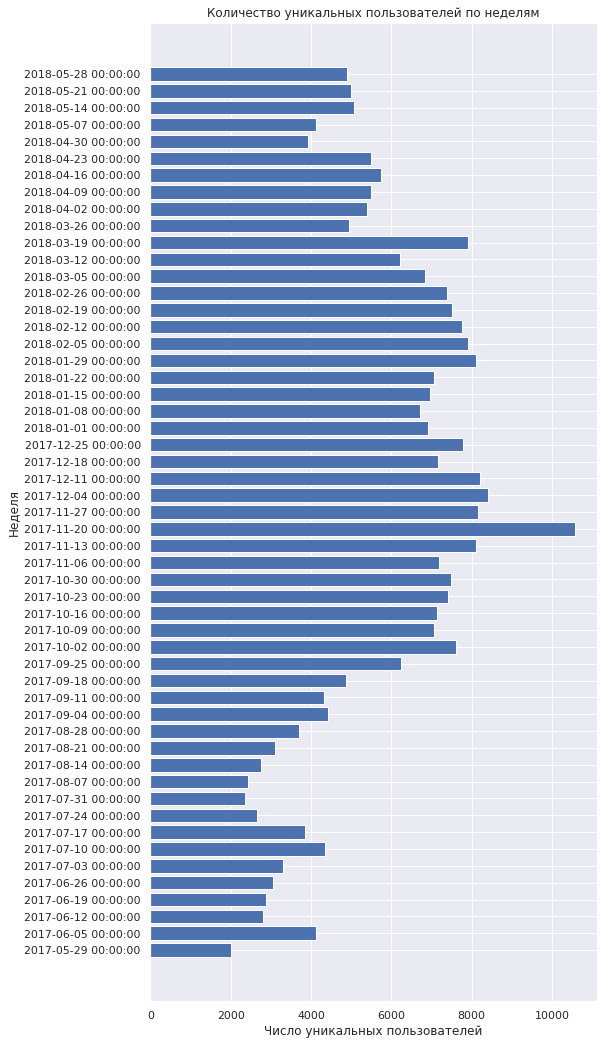

In [20]:
visits_weekly_number = visits.groupby('visit_week').agg({'uid':'nunique'}).reset_index()
index = np.arange(len(visits_weekly_number))
sns.set(rc={'figure.figsize':(8,18)})
plt.barh(index, visits_weekly_number.uid)
plt.ylabel('Неделя')
plt.xlabel('Число уникальных пользователей')
plt.yticks(index, visits_weekly_number.visit_week)
plt.title('Количество уникальных пользователей по неделям')
plt.show()

Понедельный анализ также подтверждает сезонную динамику.

In [21]:
visits_weekly_number.mean()

uid    5716.245283
dtype: float64

Еженедельно в исследуемый период Яндекс.Афишу посещали в среднем 5716 уникальных пользователей.

Поскольку дней слишком много для непосредственного анализа, посмотрим на динамику среднедневного количества визитов по месяцам.

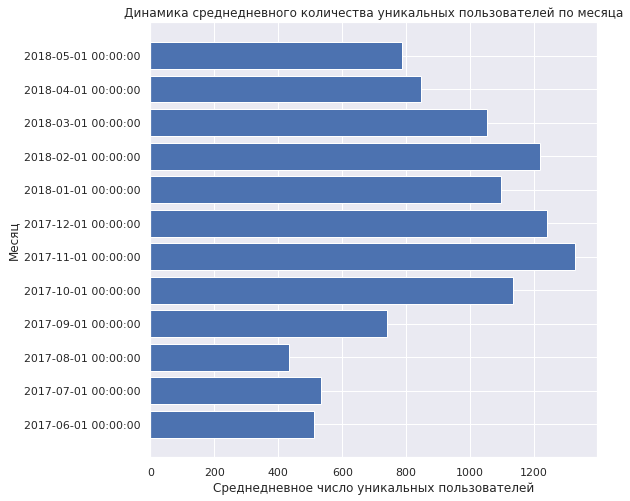

In [22]:
visits_daily_number = visits.groupby(['visit_month','visit_day']).agg({'uid':'nunique'}).reset_index().pivot_table(index='visit_month',values='uid',aggfunc='mean').reset_index()
index = np.arange(len(visits_daily_number))
sns.set(rc={'figure.figsize':(8,8)})
plt.barh(index, visits_daily_number.uid)
plt.ylabel('Месяц')
plt.xlabel('Среднедневное число уникальных пользователей')
plt.yticks(index, visits_daily_number.visit_month)
plt.title('Динамика среднедневного количества уникальных пользователей по месяца')
plt.show()

С октября по март на Яндекс.Афишу в среднем заходит более 1000 уникальных пользователей в день.  
В остальные месяцы показатель скромнее.

Посчитаем количество сессий в день на одного пользователя.  
Для этого сгруппируем данные по дням и уникальным пользователям.

In [23]:
sessions_daily = visits.groupby(['visit_month','visit_day','uid']).agg({'start_ts':'count'}).reset_index()
sessions_daily.head(10)

,visit_month,visit_day,uid,start_ts
0,2017-06-01,2017-06-01,32197920403662046,1
1,2017-06-01,2017-06-01,184148767273119549,2
2,2017-06-01,2017-06-01,254239507810036143,1
3,2017-06-01,2017-06-01,258099436367309303,1
4,2017-06-01,2017-06-01,300776506671194537,1
5,2017-06-01,2017-06-01,321069768889378113,1
6,2017-06-01,2017-06-01,374683301246067167,1
7,2017-06-01,2017-06-01,385619727271643289,1
8,2017-06-01,2017-06-01,397723557959664980,1
9,2017-06-01,2017-06-01,461906529430190072,1


Проанализируем количество сессий в день на одного пользователя по месяцам.

In [24]:
print(sessions_daily.pivot_table(index='visit_month', values='start_ts', aggfunc='mean'))

             start_ts
visit_month          
2017-06-01   1.073303
2017-07-01   1.076937
2017-08-01   1.066041
2017-09-01   1.075185
2017-10-01   1.075568
2017-11-01   1.100303
2017-12-01   1.089108
2018-01-01   1.084289
2018-02-01   1.088732
2018-03-01   1.090185
2018-04-01   1.079759
2018-05-01   1.090484


В среднем, количество сессий в день у одного пользователя не сильно превышает единицу.  
Построим еще гистограмму распределения по количеству визитов за день.

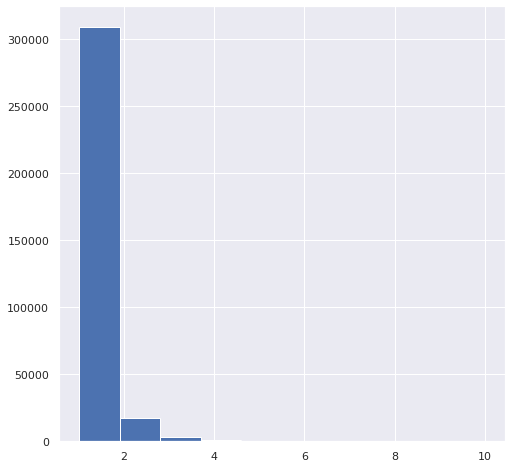

In [25]:
sessions_daily['start_ts'].hist(bins=10)

Подавляющее количество пользователей заходят на сайт Яндекс.Афиши только раз в день.

Интересно также посмотреть на количество сессий в зависимости от устройства.  
Построим сводную таблицу с количеством сессий по месяцам, в столбцах будет тип устройства.  
Добавим столбец с долей устройства desktop.

In [26]:
sessions_by_device = visits.pivot_table(index='visit_month', columns = 'device', values='start_ts', aggfunc='count').reset_index()
sessions_by_device['desktop_share'] = sessions_by_device['desktop'] / (sessions_by_device['desktop'] + sessions_by_device['touch'])
sessions_by_device

device,visit_month,desktop,touch,desktop_share
0,2017-06-01,12307,4136,0.748464
1,2017-07-01,12904,4859,0.726454
2,2017-08-01,10828,3490,0.756251
3,2017-09-01,17304,6535,0.725869
4,2017-10-01,27315,10474,0.722829
5,2017-11-01,32831,11037,0.748404
6,2017-12-01,31046,10852,0.740990
7,2018-01-01,26527,10341,0.719513
8,2018-02-01,27020,10084,0.728223
9,2018-03-01,25784,9792,0.724758


Доля заходов со стационарных компьютеров достаточно стабильна, составляет 70-75%.

Определим длину одной сессии. Для этого создадим столбец с разницей end_ts - start_ts.

In [27]:
visits['session_duration'] = visits['end_ts'] - visits['start_ts']
visits.head(10)

,uid,device,end_ts,source_id,start_ts,visit_month,visit_day,visit_week,session_duration
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,2017-12-01,2017-12-20,2017-12-18,00:18:00
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,2018-02-01,2018-02-19,2018-02-19,00:28:00
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,2017-07-01,2017-07-01,2017-06-26,00:00:00
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,2018-05-01,2018-05-20,2018-05-14,00:24:00
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,2017-12-01,2017-12-27,2017-12-25,00:00:00
5,16007536194108375387,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,2017-09-01,2017-09-03,2017-08-28,00:01:00
6,6661610529277171451,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,2018-01-01,2018-01-30,2018-01-29,00:56:00
7,11423865690854540312,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,2017-11-01,2017-11-05,2017-10-30,00:01:00
8,2987360259350925644,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2017-07-01,2017-07-19,2017-07-17,00:03:00
9,1289240080042562063,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,2017-11-01,2017-11-08,2017-11-06,00:01:00


Взглянем на основные характеристики столбца.

In [28]:
visits['session_duration'].describe()

count                    358532
mean     0 days 00:10:44.536443
std      0 days 00:16:37.860630
min           -1 days +23:14:00
25%             0 days 00:02:00
50%             0 days 00:05:00
75%             0 days 00:14:00
max             0 days 11:51:00
Name: session_duration, dtype: object

Есть даже отрицательные значения!  
Посмотрим, сколько их.

In [29]:
visits['session_duration'].sort_values().head(10)

177972   -1 days +23:14:00
4181     -1 days +23:28:00
333942            00:00:00
294610            00:00:00
294613            00:00:00
190126            00:00:00
294614            00:00:00
190105            00:00:00
320516            00:00:00
58601             00:00:00
Name: session_duration, dtype: timedelta64[ns]

In [30]:
visits.loc[177972]

uid                 4621202742905035453
device                          desktop
end_ts              2018-03-25 03:09:00
source_id                             9
start_ts            2018-03-25 03:55:00
visit_month         2018-03-01 00:00:00
visit_day           2018-03-25 00:00:00
visit_week          2018-03-19 00:00:00
session_duration      -1 days +23:14:00
Name: 177972, dtype: object

Немного - всего лишь два. И это ошибка: перепутано время начала и окончания сессии.  
Построим гистограмму со временем сессии.  
Для начала создадим столбец с длительностью сессии в минутах в формате int.  
Исправим ошибку с длительностью.

In [31]:
visits['session_duration_minutes'] = visits['session_duration'].dt.total_seconds().div(60).astype(int)
visits.loc[177972,'session_duration_minutes'] = 46
visits.loc[4181,'session_duration_minutes'] = 32
visits['session_duration_minutes'].describe()

count    358532.000000
mean         10.742709
std          16.630729
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: session_duration_minutes, dtype: float64

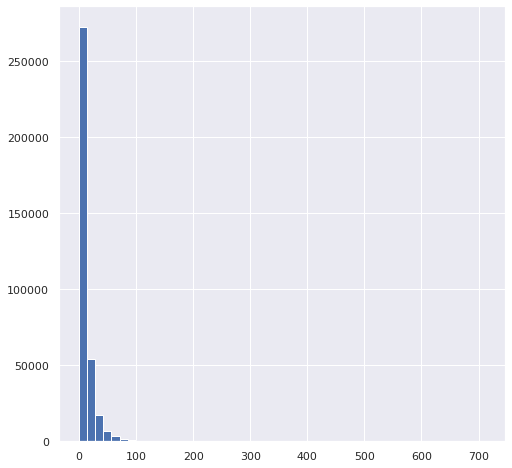

In [32]:
visits['session_duration_minutes'].hist(bins=50)

Несмотря на некоторое количество крайне длительных сессий, подавляющее большинство - короче 100 минут, а половина - менее 5 минут.    
Посмотрим на этот диапазон подробнее.

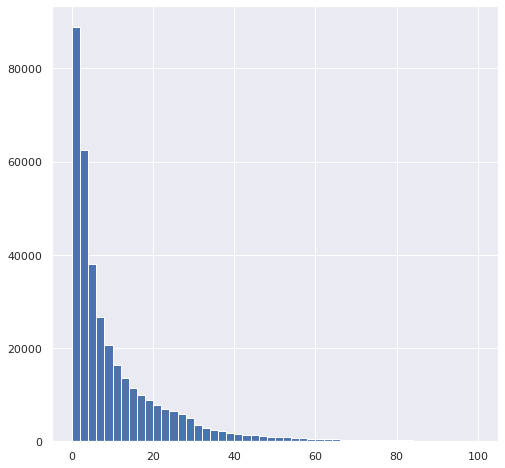

In [33]:
visits['session_duration_minutes'].hist(range=(0,100),bins=50)

Из=за длинного "хвоста" среднее превышает медиану почти в два раза.

Проанализируем длительность сессий в зависимости от типа устройства.

In [34]:
print(visits.query('device == "touch"')['session_duration_minutes'].median())
print(visits.query('device == "desktop"')['session_duration_minutes'].median())

3.0
6.0


Медианная длительность сессий при заходе на сайт с компьютеров в 2 раза выше, чем при заходе с мобильных устройств.

Для ответа на вопрос "Как часто люди возвращаются" посчитаем Retention Rate.  
Для начала разделим пользователей на месячные когорты, в зависимости от первого месяца использования.

In [35]:
first_activity_date = visits.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date,on='uid')
visits.head()

,uid,device,end_ts,source_id,start_ts,visit_month,visit_day,visit_week,session_duration,session_duration_minutes,first_activity_date
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,2017-12-01,2017-12-20,2017-12-18,00:18:00,18,2017-12-20 17:20:00
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,2018-02-01,2018-02-19,2018-02-19,00:28:00,28,2018-02-19 16:53:00
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,2017-07-01,2017-07-01,2017-06-26,00:00:00,0,2017-07-01 01:54:00
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,2018-05-01,2018-05-20,2018-05-14,00:24:00,24,2018-03-09 20:05:00
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,2017-12-01,2017-12-27,2017-12-25,00:00:00,0,2017-12-27 14:06:00


Теперь выделим столбец с месяцем первой активности для формирования когорт.

In [36]:
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits.head()

,uid,device,end_ts,source_id,start_ts,visit_month,visit_day,visit_week,session_duration,session_duration_minutes,first_activity_date,first_activity_month
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,2017-12-01,2017-12-20,2017-12-18,00:18:00,18,2017-12-20 17:20:00,2017-12-01
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,2018-02-01,2018-02-19,2018-02-19,00:28:00,28,2018-02-19 16:53:00,2018-02-01
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,2017-07-01,2017-07-01,2017-06-26,00:00:00,0,2017-07-01 01:54:00,2017-07-01
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,2018-05-01,2018-05-20,2018-05-14,00:24:00,24,2018-03-09 20:05:00,2018-03-01
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,2017-12-01,2017-12-27,2017-12-25,00:00:00,0,2017-12-27 14:06:00,2017-12-01


Теперь для каждой строки датафрейма можно рассчитать lifetime пользователя в рамках когорты.

In [37]:
visits['cohort_lifetime'] = visits['visit_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype(int)
visits.head(10)

,uid,device,end_ts,source_id,start_ts,visit_month,visit_day,visit_week,session_duration,session_duration_minutes,first_activity_date,first_activity_month,cohort_lifetime
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,2017-12-01,2017-12-20,2017-12-18,00:18:00,18,2017-12-20 17:20:00,2017-12-01,0
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,2018-02-01,2018-02-19,2018-02-19,00:28:00,28,2018-02-19 16:53:00,2018-02-01,0
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,2017-07-01,2017-07-01,2017-06-26,00:00:00,0,2017-07-01 01:54:00,2017-07-01,0
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,2018-05-01,2018-05-20,2018-05-14,00:24:00,24,2018-03-09 20:05:00,2018-03-01,2
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,2017-12-01,2017-12-27,2017-12-25,00:00:00,0,2017-12-27 14:06:00,2017-12-01,0
5,16007536194108375387,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,2017-09-01,2017-09-03,2017-08-28,00:01:00,1,2017-09-03 21:35:00,2017-09-01,0
6,6661610529277171451,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,2018-01-01,2018-01-30,2018-01-29,00:56:00,56,2017-06-29 09:00:00,2017-06-01,7
7,11423865690854540312,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,2017-11-01,2017-11-05,2017-10-30,00:01:00,1,2017-11-05 15:14:00,2017-11-01,0
8,2987360259350925644,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2017-07-01,2017-07-19,2017-07-17,00:03:00,3,2017-07-19 10:41:00,2017-07-01,0
9,1289240080042562063,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,2017-11-01,2017-11-08,2017-11-06,00:01:00,1,2017-11-08 13:42:00,2017-11-01,0


Сгруппируем данные по когорте и lifetime.  
Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни».

In [38]:
cohorts = visits.groupby(['first_activity_month','visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts.head(10)

,first_activity_month,visit_month,cohort_lifetime,uid
0,2017-06-01,2017-06-01,0,13259
1,2017-06-01,2017-07-01,1,1043
2,2017-06-01,2017-08-01,2,713
3,2017-06-01,2017-09-01,3,814
4,2017-06-01,2017-10-01,4,909
5,2017-06-01,2017-11-01,5,947
6,2017-06-01,2017-12-01,6,809
7,2017-06-01,2018-01-01,7,766
8,2017-06-01,2018-02-01,8,694
9,2017-06-01,2018-03-01,9,674


Чтобы найти Retention Rate, получим число пользователей, изначально бывших в когорте, и на него разделим число пользователей в каждую следующий месяц.

In [39]:
inital_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
inital_users_count

,first_activity_month,uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [40]:
inital_users_count = inital_users_count.rename(columns={'uid':'cohort_users'}) # переименуем столбец
cohorts = cohorts.merge(inital_users_count,on='first_activity_month') # добавим в датафрейм с когортами информацию об исходном количестве пользователей в когорте
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] # рассчитаем Retention Rate
cohorts.head(10)

,first_activity_month,visit_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,2017-07-01,1,1043,13259,0.078664
2,2017-06-01,2017-08-01,2,713,13259,0.053775
3,2017-06-01,2017-09-01,3,814,13259,0.061392
4,2017-06-01,2017-10-01,4,909,13259,0.068557
5,2017-06-01,2017-11-01,5,947,13259,0.071423
6,2017-06-01,2017-12-01,6,809,13259,0.061015
7,2017-06-01,2018-01-01,7,766,13259,0.057772
8,2017-06-01,2018-02-01,8,694,13259,0.052342
9,2017-06-01,2018-03-01,9,674,13259,0.050833


Для наглядности построим тепловую карту.

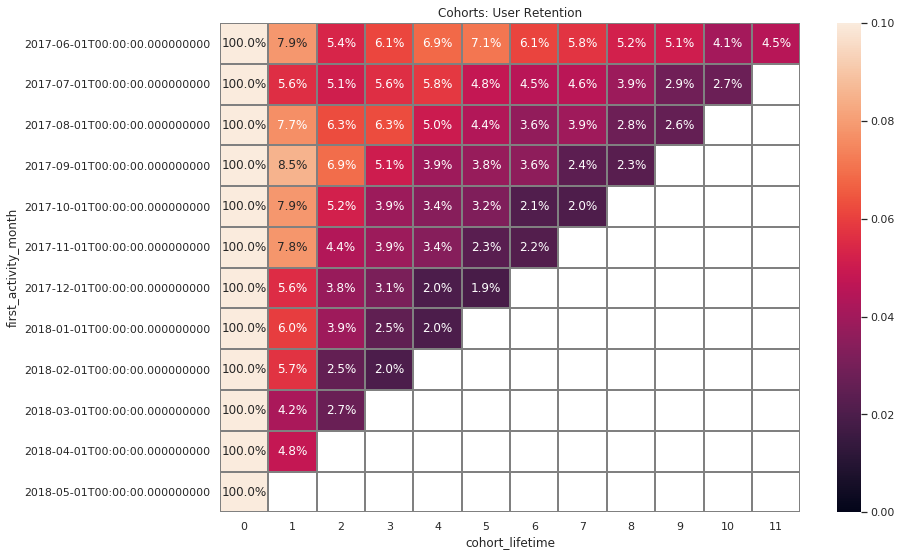

In [41]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=0, vmax=0.1)

Не имея данных о Retention Rate по другим проектам, сложно судить о том, насколько хороши или плохи эти цифры, но на первый взгляд Retention Rate кажется низким.  
С другой стороны, вероятно, мы не можем в прямом смысле считать получившиеся группы когортами: ведь мы не знаем истории пользования до июня 2017 - возможно, это далеко не новые пользователи...

### Метрики продаж

В отношении продаж нам необходимо ответить на следующие вопросы:  
•	Когда люди начинают покупать?  
•	Сколько раз покупают за период?  
•	Какой средний чек?  
•	Сколько денег приносят? (LTV)  

Вопрос о начале покупок - это вопрос о временном диапазоне между первым визитом и первой покупкой.  
Будем действовать в соответствии со следующей логикой:  
- создадим датафрейм с информацией о самой первой активности пользователя из таблицы visits;
- создадим датафрейм с информацией о самой ранней покупке пользователя из таблицы orders;
- объединим полученные датафреймы (поскольку могут присутствовать пользователи, которые не совершили покупок, объединим на основе uid из датафрейма с визитами).

In [42]:
first_visits_orders_date = visits.groupby(['uid'])['start_ts'].min().reset_index()
first_visits_orders_date.head()

,uid,start_ts
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [43]:
first_order_date = orders.groupby(['uid'])['buy_ts'].min()
first_order_date.name = 'first_order_date'
first_visits_orders_date = first_visits_orders_date.merge(first_order_date,on='uid', how='left')
first_visits_orders_date.head()

,uid,start_ts,first_order_date
0,11863502262781,2018-03-01 17:27:00,NaT
1,49537067089222,2018-02-06 15:55:00,NaT
2,297729379853735,2017-06-07 18:47:00,NaT
3,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
4,325320750514679,2017-09-30 14:29:00,NaT


Очевидно, что далеко не все посетители совершили покупку.  
Создадим датафрейм только с теми посетителями, которые совершили покупку.  
Затем рассчитаем период, который прошел между первым визитом и первой покупкой, и приведем его к количеству часов.

In [44]:
first_visits_orders_date = first_visits_orders_date.rename(columns={'start_ts':'first_activity_date'}) # переименуем столбец
purchasers = first_visits_orders_date[~first_visits_orders_date.first_order_date.isnull()]
purchasers['time_to_order'] = purchasers['first_order_date'] - purchasers['first_activity_date']
purchasers['minutes_to_order'] = purchasers['time_to_order'] / np.timedelta64(1, 'm')
purchasers['minutes_to_order'] = purchasers['minutes_to_order'].round().astype('int')
purchasers.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,uid,first_activity_date,first_order_date,time_to_order,minutes_to_order
3,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106 days 23:02:00,154022
22,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00,0
35,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0 days 01:19:00,79
36,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,0 days 19:44:00,1184
38,2551852515556206,2017-11-24 11:22:00,2017-11-24 10:14:00,-1 days +22:52:00,-68


In [45]:
purchasers['minutes_to_order'].describe()

count     36523.000000
mean      24335.556115
std       67786.449962
min       -1437.000000
25%           4.000000
50%          16.000000
75%        2897.000000
max      523144.000000
Name: minutes_to_order, dtype: float64

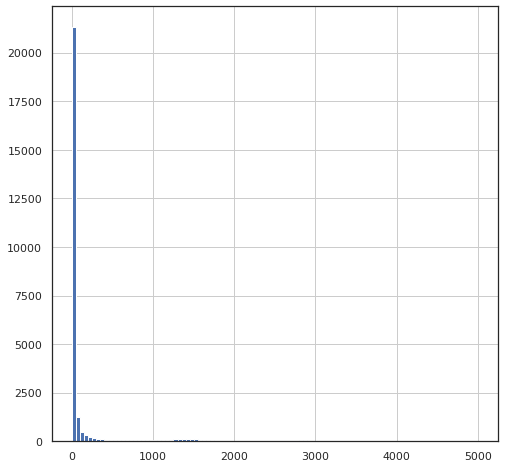

In [46]:
purchasers['minutes_to_order'].hist(range=(0,5000), bins=100)

Если покупка совершается, то в подавляющем числе случаев - непосредственно в течение часа-двух после первого визита!

Думаю, что всплекс в районе 1500 минут (через сутки) связан с наличием сегмента посетителей, который покупают не сразу )

Следующий вопрос - частота покупок за период.  
Создадим следующий датафрейм:
- для каждой когорты посетителей сайта помесячно сохраним информацию о количестве посетителей, количестве покупателей, количестве покупок и совокупной выручке.

In [47]:
orders['visit_month'] = orders['buy_ts'].astype('datetime64[M]') # добавим в датафрейм с покупками столбец с месяцем
orders['visit_month'].describe()

count                   50415
unique                     12
top       2017-12-01 00:00:00
freq                     6218
first     2017-06-01 00:00:00
last      2018-05-01 00:00:00
Name: visit_month, dtype: object

In [48]:
cohort_list = visits.loc[:,['uid','first_activity_month']].drop_duplicates().reset_index(drop=True) # создадим датафрейм с указанием когорты для каждого уникального посетителя
cohort_list.head(10)

,uid,first_activity_month
0,16879256277535980062,2017-12-01
1,104060357244891740,2018-02-01
2,7459035603376831527,2017-07-01
3,16174680259334210214,2018-03-01
4,9969694820036681168,2017-12-01
5,16007536194108375387,2017-09-01
6,6661610529277171451,2017-06-01
7,11423865690854540312,2017-11-01
8,2987360259350925644,2017-07-01
9,1289240080042562063,2017-11-01


In [49]:
orders = orders.merge(cohort_list,on='uid', how='left') # добавим столбец с когортой в датафрейм с покупками
orders.head(10)

,buy_ts,revenue,uid,visit_month,first_activity_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,2017-06-01
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,2017-06-01
7,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01
8,2017-06-01 09:22:00,3.30,17542070709969841479,2017-06-01,2017-06-01
9,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01,2017-06-01


In [50]:
cohorts_orders_monthly = orders.pivot_table(index=['first_activity_month','visit_month'],values=['buy_ts','uid','revenue'],aggfunc={'buy_ts':'count','uid':'nunique','revenue':'sum'}).reset_index()
cohorts_orders_monthly.head()

,first_activity_month,visit_month,buy_ts,revenue,uid
0,2017-06-01,2017-06-01,2354,9557.49,2023
1,2017-06-01,2017-07-01,387,2664.58,231
2,2017-06-01,2017-08-01,273,1464.69,129
3,2017-06-01,2017-09-01,442,3882.09,188
4,2017-06-01,2017-10-01,516,3940.59,257


Теперь если добавить количество пользователей по месяцам и когортам, у нас будет вся информация для дальнейшего анализа.

In [51]:
cohorts_orders_monthly.set_axis(['first_activity_month','visit_month','orders_n','revenue','purchasers'],axis = 'columns',inplace = True)
cohorts.set_axis(['first_activity_month','visit_month','cohort_lifetime','visitors','cohort_users','retention'],axis = 'columns',inplace = True)
cohorts = cohorts.merge(cohorts_orders_monthly, how='left', left_on=['first_activity_month','visit_month'], right_on=['first_activity_month','visit_month'])
cohorts.head()

,first_activity_month,visit_month,cohort_lifetime,visitors,cohort_users,retention,orders_n,revenue,purchasers
0,2017-06-01,2017-06-01,0,13259,13259,1.000000,2354,9557.49,2023
1,2017-06-01,2017-07-01,1,1043,13259,0.078664,387,2664.58,231
2,2017-06-01,2017-08-01,2,713,13259,0.053775,273,1464.69,129
3,2017-06-01,2017-09-01,3,814,13259,0.061392,442,3882.09,188
4,2017-06-01,2017-10-01,4,909,13259,0.068557,516,3940.59,257


Добавим несколько дополнительных столбцов:
    - средний чек;
    - доля покупателей среди посетителей;
    - количество заказов на одного покупателя

In [52]:
cohorts['average_check'] = cohorts['revenue'] / cohorts['orders_n']
cohorts['purch_share'] = cohorts['purchasers'] / cohorts['visitors']
cohorts['orders_per_purch'] = cohorts['orders_n'] / cohorts['purchasers']
cohorts.head(10)

,first_activity_month,visit_month,cohort_lifetime,visitors,cohort_users,retention,orders_n,revenue,purchasers,average_check,purch_share,orders_per_purch
0,2017-06-01,2017-06-01,0,13259,13259,1.000000,2354,9557.49,2023,4.060106,0.152576,1.163618
1,2017-06-01,2017-07-01,1,1043,13259,0.078664,387,2664.58,231,6.885220,0.221477,1.675325
2,2017-06-01,2017-08-01,2,713,13259,0.053775,273,1464.69,129,5.365165,0.180926,2.116279
3,2017-06-01,2017-09-01,3,814,13259,0.061392,442,3882.09,188,8.783009,0.230958,2.351064
4,2017-06-01,2017-10-01,4,909,13259,0.068557,516,3940.59,257,7.636802,0.282728,2.007782
5,2017-06-01,2017-11-01,5,947,13259,0.071423,428,2824.48,203,6.599252,0.214361,2.108374
6,2017-06-01,2017-12-01,6,809,13259,0.061015,500,3489.95,189,6.979900,0.233622,2.645503
7,2017-06-01,2018-01-01,7,766,13259,0.057772,329,2270.81,155,6.902158,0.202350,2.122581
8,2017-06-01,2018-02-01,8,694,13259,0.052342,371,2317.91,172,6.247736,0.247839,2.156977
9,2017-06-01,2018-03-01,9,674,13259,0.050833,318,3481.64,156,10.948553,0.231454,2.038462


Построим несколько тепловых карт для лучшего понимания ситуации.  

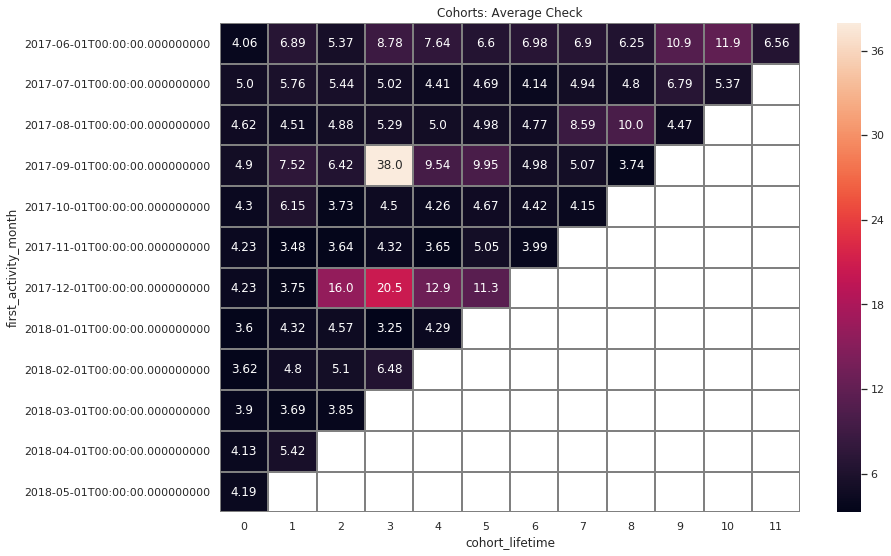

In [53]:
check_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='average_check',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Average Check')
sns.heatmap(check_pivot, annot=True, fmt='.3', linewidths=1, linecolor='gray')

Четкой тенденции в отношении среднего чека в зависимости от возраста когорты не наблюдается, при этом отдельные всплески присутствуют.

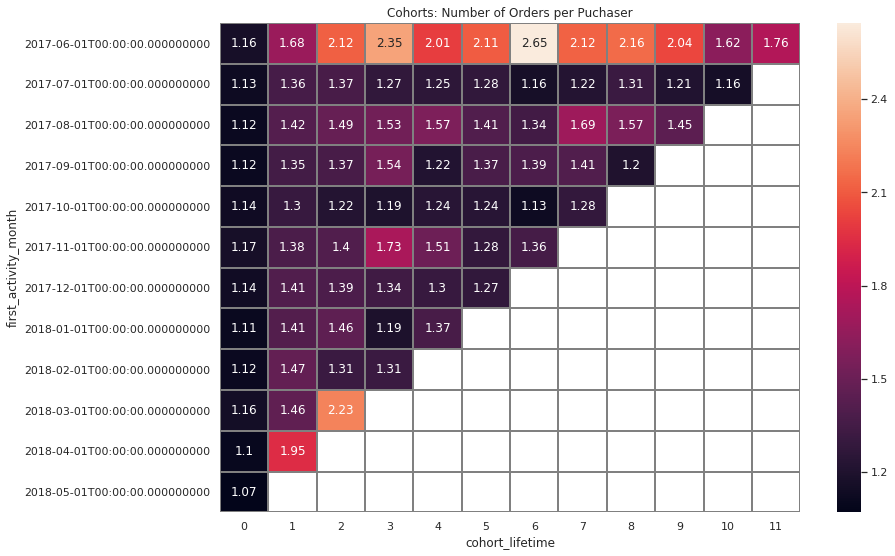

In [54]:
orders_per_p_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='orders_per_purch',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Number of Orders per Puchaser')
sns.heatmap(orders_per_p_pivot, annot=True, fmt='.3', linewidths=1, linecolor='gray')

Любопытно, что первая когорта в целом чаще совершает покупке в течение всего периода "жизни".

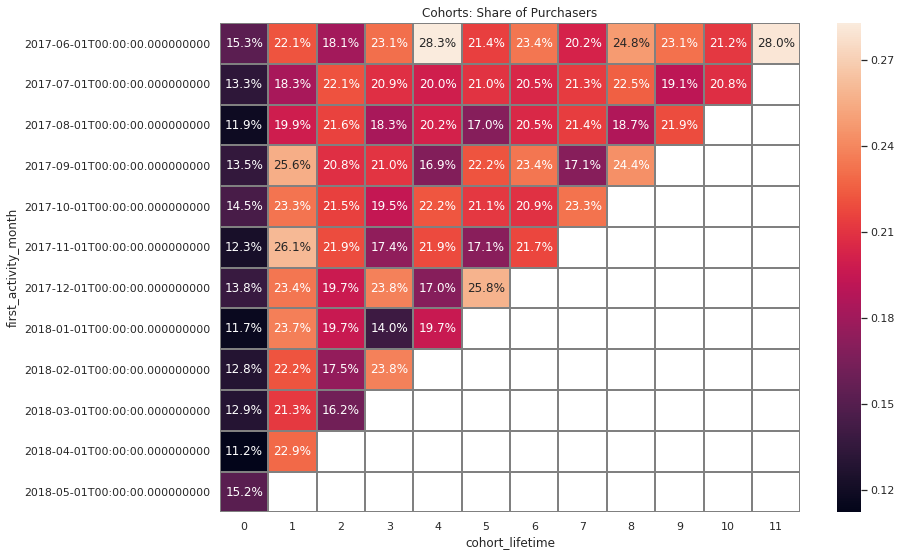

In [55]:
purch_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='purch_share',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Share of Purchasers')
sns.heatmap(purch_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')

Заметных отличий доли покупателей в зависимости от когорты и ее возраста не наблюдается.  
Интересно отметить лишь, что ниже всего доля покупателей в первый месяц "жизни" когорты.

Возможно, есть сезонность по этим показателям, можно попробовать построить сводную таблицу по агрегированным по месяцам данным (без разбивки по когортам).

In [56]:
data_by_months = cohorts.pivot_table(index='visit_month',values=['visitors','purchasers','revenue','orders_n'],aggfunc={'visitors':'sum','purchasers':'sum','revenue':'sum','orders_n':'sum'})
data_by_months['average_check'] = data_by_months['revenue'] / data_by_months['orders_n']
data_by_months['purch_share'] = data_by_months['purchasers'] / data_by_months['visitors']
data_by_months['orders_per_purch'] = data_by_months['orders_n'] / data_by_months['purchasers']
data_by_months

,orders_n,purchasers,revenue,visitors,average_check,purch_share,orders_per_purch
visit_month,,,,,,,
2017-06-01,2354,2023,9557.49,13259,4.060106,0.152576,1.163618
2017-07-01,2363,1984,12539.47,14183,5.306589,0.139886,1.191028
2017-08-01,1807,1472,8758.78,11631,4.847139,0.126558,1.227582
2017-09-01,3387,2750,18345.51,18975,5.416448,0.144928,1.231636
2017-10-01,5679,4675,27987.70,29692,4.928280,0.157450,1.214759
2017-11-01,5659,4547,27069.93,32797,4.783518,0.138641,1.244557
2017-12-01,6218,4942,36388.60,31557,5.852139,0.156606,1.258195
2018-01-01,4721,3898,19417.13,28716,4.112927,0.135743,1.211134
2018-02-01,5281,4258,25560.54,28749,4.840095,0.148109,1.240254


Заметной сезонности в отношении среднего чека, доли покупателей среди посетитилей и количества покупок в месяц на одного покупателя не наблюдается.  
- Средний чек колеблется от 4 до 6 рублей (по всей видимости, комиссия Яндекс.Афиши при покупках билетов)
- Доля покупателей от посетителей в районе 15% в среднем
- Средний покупатель делает 1,2 заказа в месяц.

Теперь посчитаем LTV.  
Найдем размеры когорт по покупателям.

In [57]:
first_orders = orders.groupby('uid').agg({'first_activity_month': 'min'}).reset_index()
first_orders.head()

,uid,first_activity_month
0,313578113262317,2017-09-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


Посчитаем количество новых покупателей (n_buyers) за каждый месяц.

In [58]:
cohort_buyers_sizes = first_orders.groupby('first_activity_month').agg({'uid': 'nunique'}).reset_index()
cohort_buyers_sizes.columns = ['first_activity_month', 'n_buyers']
cohort_buyers_sizes

,first_activity_month,n_buyers
0,2017-06-01,2923
1,2017-07-01,2458
2,2017-08-01,1721
3,2017-09-01,3058
4,2017-10-01,4678
5,2017-11-01,4262
6,2017-12-01,4074
7,2018-01-01,3119
8,2018-02-01,3186
9,2018-03-01,2838


Сгруппируем таблицу заказов по месяцу первой активности и месяцу каждого заказа и сложим выручку. 

In [59]:
cohorts_buyers = orders.groupby(['first_activity_month','visit_month']).agg({'revenue': 'sum'}).reset_index()
cohorts_buyers.head(10)

,first_activity_month,visit_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,2664.58
2,2017-06-01,2017-08-01,1464.69
3,2017-06-01,2017-09-01,3882.09
4,2017-06-01,2017-10-01,3940.59
5,2017-06-01,2017-11-01,2824.48
6,2017-06-01,2017-12-01,3489.95
7,2017-06-01,2018-01-01,2270.81
8,2017-06-01,2018-02-01,2317.91
9,2017-06-01,2018-03-01,3481.64


Добавим в таблицу данные о том, сколько людей первый раз совершили покупку в каждый месяц.

In [60]:
report_cohort_buyers = pd.merge(cohort_buyers_sizes, cohorts_buyers, on='first_activity_month')
report_cohort_buyers.head()

,first_activity_month,n_buyers,visit_month,revenue
0,2017-06-01,2923,2017-06-01,9557.49
1,2017-06-01,2923,2017-07-01,2664.58
2,2017-06-01,2923,2017-08-01,1464.69
3,2017-06-01,2923,2017-09-01,3882.09
4,2017-06-01,2923,2017-10-01,3940.59


LTV удобнее смотреть по «возрастным» когортам, где в столбцах — не месяц заказа, а возраст (age) когорты.

In [61]:
report_cohort_buyers['age'] = (report_cohort_buyers['visit_month'] - report_cohort_buyers['first_activity_month']) / np.timedelta64(1, 'M')
report_cohort_buyers['age'] = report_cohort_buyers['age'].round().astype('int')
report_cohort_buyers.head(10)

,first_activity_month,n_buyers,visit_month,revenue,age
0,2017-06-01,2923,2017-06-01,9557.49,0
1,2017-06-01,2923,2017-07-01,2664.58,1
2,2017-06-01,2923,2017-08-01,1464.69,2
3,2017-06-01,2923,2017-09-01,3882.09,3
4,2017-06-01,2923,2017-10-01,3940.59,4
5,2017-06-01,2923,2017-11-01,2824.48,5
6,2017-06-01,2923,2017-12-01,3489.95,6
7,2017-06-01,2923,2018-01-01,2270.81,7
8,2017-06-01,2923,2018-02-01,2317.91,8
9,2017-06-01,2923,2018-03-01,3481.64,9


Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте.  
Для наглядности визуализируем когорты в виде сводной таблицы.

In [62]:
report_cohort_buyers['ltv'] = report_cohort_buyers['revenue'] / report_cohort_buyers['n_buyers']
    
output = report_cohort_buyers.pivot_table(
        index='first_activity_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2)
    
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,3.27,0.91,0.5,1.33,1.35,0.97,1.19,0.78,0.79,1.19,0.75,0.66
2017-07-01,4.02,0.43,0.45,0.4,0.34,0.32,0.24,0.31,0.29,0.24,0.19,
2017-08-01,3.62,0.58,0.58,0.55,0.47,0.31,0.28,0.72,0.48,0.22,,
2017-09-01,4.04,1.21,0.69,3.41,0.42,0.62,0.32,0.16,0.14,,,
2017-10-01,3.93,0.81,0.28,0.23,0.22,0.22,0.12,0.14,,,,
2017-11-01,3.88,0.63,0.32,0.32,0.26,0.17,0.16,,,,,
2017-12-01,4.14,0.43,1.03,1.26,0.36,0.44,,,,,,
2018-01-01,3.40,0.63,0.37,0.1,0.17,,,,,,,
2018-02-01,3.61,0.62,0.21,0.28,,,,,,,,


Основной доход покупатели приносят в первый месяц "жизни", из-за низкого retention rate.

Возьмем в качестве срока "жизни" клиента 6 месяцев, и посчитаем суммарный LTV для имеющихся когорт.

In [63]:
output['six_months'] = output.iloc[:,0:5].sum(axis=1)
output

age,0,1,2,3,4,5,6,7,8,9,10,11,six_months
first_activity_month,,,,,,,,,,,,,
2017-06-01,3.27,0.91,0.50,1.33,1.35,0.97,1.19,0.78,0.79,1.19,0.75,0.66,7.36
2017-07-01,4.02,0.43,0.45,0.40,0.34,0.32,0.24,0.31,0.29,0.24,0.19,NaN,5.64
2017-08-01,3.62,0.58,0.58,0.55,0.47,0.31,0.28,0.72,0.48,0.22,NaN,NaN,5.80
2017-09-01,4.04,1.21,0.69,3.41,0.42,0.62,0.32,0.16,0.14,NaN,NaN,NaN,9.77
2017-10-01,3.93,0.81,0.28,0.23,0.22,0.22,0.12,0.14,NaN,NaN,NaN,NaN,5.47
2017-11-01,3.88,0.63,0.32,0.32,0.26,0.17,0.16,NaN,NaN,NaN,NaN,NaN,5.41
2017-12-01,4.14,0.43,1.03,1.26,0.36,0.44,NaN,NaN,NaN,NaN,NaN,NaN,7.22
2018-01-01,3.40,0.63,0.37,0.10,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.67
2018-02-01,3.61,0.62,0.21,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.72


Посчитаем средний LTV для семи когорт, которые уже "прожили" нужный период.

In [64]:
output.iloc[0:6,12].mean()

6.575

В среднем, покупатели приносят за 6 месяцев 6.6 рублей.

### Маркетинг

На этом этапе необходимо решить следующие задачи:  
•	Сколько денег потратили? Всего / на каждый источник / по времени  
•	Сколько стоило привлечение одного покупателя из каждого источника?  
•	На сколько окупились расходы? (ROI)

Построим сводную таблицу с данными о суммарных расходах на каждый источник помесячно.

In [65]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs_report = costs.pivot_table(index='month',columns='source_id',values='costs',aggfunc='sum').round()
costs_report

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,1126.0,2427.0,7732.0,3515.0,2616.0,285.0,314.0
2017-07-01,1073.0,2333.0,7674.0,3530.0,2998.0,303.0,330.0
2017-08-01,952.0,1811.0,6144.0,3217.0,2185.0,249.0,233.0
2017-09-01,1502.0,2986.0,9964.0,5192.0,3849.0,416.0,461.0
2017-10-01,2316.0,4845.0,15737.0,6421.0,5767.0,609.0,627.0
2017-11-01,2445.0,5248.0,17025.0,5389.0,6325.0,683.0,792.0
2017-12-01,2341.0,4898.0,16220.0,7680.0,5873.0,658.0,646.0
2018-01-01,2186.0,4158.0,14809.0,5833.0,5372.0,547.0,614.0
2018-02-01,2204.0,4474.0,14229.0,5712.0,5071.0,552.0,481.0


Построим тепловую карту.

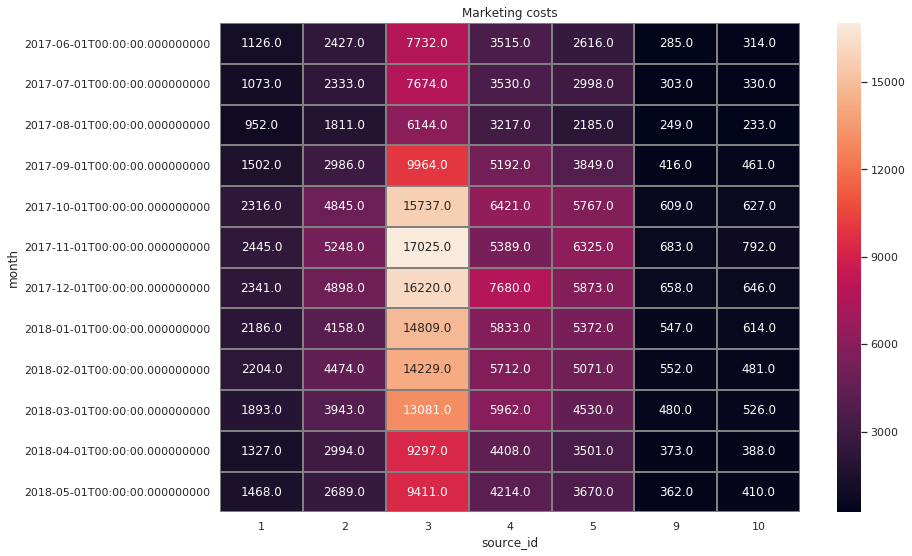

In [66]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Marketing costs')
sns.heatmap(costs_report, annot=True, fmt='.6', linewidths=1, linecolor='gray')

Наибольшие расходы приходятся на третий источник, за которым следуют четвертый, второй и пятый.  
Также видно, что расходы на маркетинг с сентября по май выше, чем летом.

Для того, чтобы оценить стоимость привлечения одного покупателя из каждого источника, сделаем следующий датафрейм:
- месяц
- источник
- количество новых покупателей, привлеченных в этот месяц из этого источника
- затраты на привлечение покупателей в этот месяц по данному источнику 

Для начала сделаем табличку с уникальными посетителями и источником их привлечения.  
Отсортируем исходный датафрейм по возрастанию на тот случай, если встречается несколько источников для одного посетителя (нам нужен первый источник), и удалим дубликаты по столбцу uid.

In [67]:
visitors_sources = visits.sort_values(by='start_ts').drop_duplicates(subset='uid').reset_index().loc[:,['uid','source_id']]
visitors_sources.head(10)

,uid,source_id
0,13890188992670018146,5
1,16706502037388497502,3
2,16152015161748786004,3
3,8842918131297115663,3
4,10329302124590727494,1
5,16109239769442553005,2
6,17384547788533003069,4
7,11627257723692907447,2
8,17903680561304213844,2
9,13136692283820170315,2


Проверим на всякий случай, что все посетители в списке.

In [68]:
print(len(visits['uid'].unique()))
print(len(visitors_sources))

228169
228169


Добавим к датафрейму first_orders (для каждого уникального покупателя указан первый месяц активности) столбец с источником привлечения.

In [69]:
first_orders_source = pd.merge(first_orders, visitors_sources, on='uid', how='left')
first_orders_source.head(10)

,uid,first_activity_month,source_id
0,313578113262317,2017-09-01,2
1,1575281904278712,2017-06-01,10
2,2429014661409475,2017-10-01,3
3,2464366381792757,2018-01-01,5
4,2551852515556206,2017-11-01,5
5,3077748354309989,2018-03-01,3
6,3605148382144603,2017-08-01,2
7,3753586865891862,2018-03-01,4
8,4808417689019433,2018-01-01,4
9,4992223027560440,2018-04-01,5


Посчитаем количество привлеченных из каждого источника помесячно.

In [70]:
cohort_sources_sizes = first_orders_source.groupby(['first_activity_month','source_id']).agg({'uid': 'nunique'}).reset_index()
cohort_sources_sizes.columns = ['first_activity_month', 'source_id','n_buyers']
cohort_sources_sizes.head()

,first_activity_month,source_id,n_buyers
0,2017-06-01,1,238
1,2017-06-01,2,372
2,2017-06-01,3,887
3,2017-06-01,4,648
4,2017-06-01,5,514


Добавим в датафрейм с заказами столбец с источником привлечения из visitors_sources.

In [71]:
orders_source = pd.merge(orders, visitors_sources, on='uid', how='left')
orders_source.head(10)

,buy_ts,revenue,uid,visit_month,first_activity_month,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,3
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,2017-06-01,3
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,2017-06-01,5
7,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01,5
8,2017-06-01 09:22:00,3.30,17542070709969841479,2017-06-01,2017-06-01,4
9,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01,2017-06-01,1


Сгруппируем таблицу заказов по источнику, месяцу первой покупки и месяцу каждого заказа и сложим выручку. 

In [72]:
cohorts_sources_buyers = orders_source.groupby(['first_activity_month','visit_month','source_id']).agg({'revenue': 'sum'}).reset_index()
cohorts_sources_buyers.head(10)

,first_activity_month,visit_month,source_id,revenue
0,2017-06-01,2017-06-01,1,1291.09
1,2017-06-01,2017-06-01,2,1036.19
2,2017-06-01,2017-06-01,3,2806.18
3,2017-06-01,2017-06-01,4,1980.73
4,2017-06-01,2017-06-01,5,1990.51
5,2017-06-01,2017-06-01,9,232.61
6,2017-06-01,2017-06-01,10,220.18
7,2017-06-01,2017-07-01,1,532.45
8,2017-06-01,2017-07-01,2,395.74
9,2017-06-01,2017-07-01,3,720.14


Добавим в таблицу данные о том, сколько людей первый раз совершили покупку в каждый месяц, привлеченные из каждого источника.

In [73]:
report_cohort_sources_buyers = pd.merge(cohorts_sources_buyers, cohort_sources_sizes, how='left', 
                                        left_on=['first_activity_month','source_id'],
                                        right_on=['first_activity_month','source_id'])
report_cohort_sources_buyers.head(10)

,first_activity_month,visit_month,source_id,revenue,n_buyers
0,2017-06-01,2017-06-01,1,1291.09,238
1,2017-06-01,2017-06-01,2,1036.19,372
2,2017-06-01,2017-06-01,3,2806.18,887
3,2017-06-01,2017-06-01,4,1980.73,648
4,2017-06-01,2017-06-01,5,1990.51,514
5,2017-06-01,2017-06-01,9,232.61,152
6,2017-06-01,2017-06-01,10,220.18,112
7,2017-06-01,2017-07-01,1,532.45,238
8,2017-06-01,2017-07-01,2,395.74,372
9,2017-06-01,2017-07-01,3,720.14,887


Для понимания окупаемости различных источников также лучше добавить возраст когорты.

In [74]:
report_cohort_sources_buyers['age'] = (report_cohort_sources_buyers['visit_month'] - report_cohort_sources_buyers['first_activity_month']) / np.timedelta64(1, 'M')
report_cohort_sources_buyers['age'] = report_cohort_sources_buyers['age'].round().astype('int')
report_cohort_sources_buyers.head(10)

,first_activity_month,visit_month,source_id,revenue,n_buyers,age
0,2017-06-01,2017-06-01,1,1291.09,238,0
1,2017-06-01,2017-06-01,2,1036.19,372,0
2,2017-06-01,2017-06-01,3,2806.18,887,0
3,2017-06-01,2017-06-01,4,1980.73,648,0
4,2017-06-01,2017-06-01,5,1990.51,514,0
5,2017-06-01,2017-06-01,9,232.61,152,0
6,2017-06-01,2017-06-01,10,220.18,112,0
7,2017-06-01,2017-07-01,1,532.45,238,1
8,2017-06-01,2017-07-01,2,395.74,372,1
9,2017-06-01,2017-07-01,3,720.14,887,1


In [75]:
report_cohort_sources_buyers['ltv'] = report_cohort_sources_buyers['revenue'] / report_cohort_sources_buyers['n_buyers']

In [76]:
output2 = report_cohort_sources_buyers.pivot_table(
        index='source_id', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2)
output2

age,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,5.00,0.94,0.75,1.20,0.66,0.60,0.49,2.40,1.67,1.40,1.69,1.89
2,4.97,1.80,1.93,2.15,1.19,1.07,0.62,0.46,0.61,0.92,0.92,1.04
3,3.62,0.65,0.28,0.28,0.27,0.21,0.20,0.15,0.18,0.14,0.12,0.17
4,3.65,0.47,0.24,0.30,0.28,0.41,0.50,0.20,0.37,0.72,0.61,1.28
5,4.17,0.56,0.36,1.82,0.49,0.52,0.41,0.36,0.34,0.56,0.20,0.17
7,1.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.44,0.72,0.54,0.53,0.46,0.25,0.38,0.34,0.57,0.37,0.25,0.10
10,2.77,0.25,0.15,0.09,0.27,0.13,0.11,0.09,0.02,0.08,0.13,0.08


Если мы берем период жизни как 6 месяцев, посчитаем суммарный ltv по каждому источнику за этот период.

In [77]:
output2['six_months'] = output2.iloc[:,0:5].sum(axis=1)
output2

age,0,1,2,3,4,5,6,7,8,9,10,11,six_months
source_id,,,,,,,,,,,,,
1,5.00,0.94,0.75,1.20,0.66,0.60,0.49,2.40,1.67,1.40,1.69,1.89,8.55
2,4.97,1.80,1.93,2.15,1.19,1.07,0.62,0.46,0.61,0.92,0.92,1.04,12.04
3,3.62,0.65,0.28,0.28,0.27,0.21,0.20,0.15,0.18,0.14,0.12,0.17,5.10
4,3.65,0.47,0.24,0.30,0.28,0.41,0.50,0.20,0.37,0.72,0.61,1.28,4.94
5,4.17,0.56,0.36,1.82,0.49,0.52,0.41,0.36,0.34,0.56,0.20,0.17,7.40
7,1.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.22
9,2.44,0.72,0.54,0.53,0.46,0.25,0.38,0.34,0.57,0.37,0.25,0.10,4.69
10,2.77,0.25,0.15,0.09,0.27,0.13,0.11,0.09,0.02,0.08,0.13,0.08,3.53


Сохраним в отдельную переменную информацию о LTV клиентов, привлеченных с помощью каждого источника.

In [78]:
LTV_sources = output2.loc[:,['six_months']]
LTV_sources

age,six_months
source_id,
1,8.55
2,12.04
3,5.10
4,4.94
5,7.40
7,1.22
9,4.69
10,3.53


In [79]:
LTV_sources = LTV_sources.reset_index()
LTV_sources

age,source_id,six_months
0,1,8.55
1,2,12.04
2,3,5.10
3,4,4.94
4,5,7.40
5,7,1.22
6,9,4.69
7,10,3.53


Посчитаем количество уникальных покупателей по месяцам, привлеченных из различных источников.  

In [80]:
sources_stat = first_orders_source.groupby(['first_activity_month','source_id']).agg({'uid':'count'}).reset_index()
sources_stat.set_axis(['month','source_id','buyers_n'],axis = 'columns',inplace = True)
sources_stat.head()

,month,source_id,buyers_n
0,2017-06-01,1,238
1,2017-06-01,2,372
2,2017-06-01,3,887
3,2017-06-01,4,648
4,2017-06-01,5,514


Сгруппируем по месяцам и источникам датасет с затратами на маркетинг.

In [81]:
costs_stat = costs.groupby(['month','source_id']).agg({'costs':'sum'}).reset_index()
costs_stat.head()

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


Теперь можно объединить датасеты.

In [82]:
marketing_costs = pd.merge(sources_stat, costs_stat, left_on=['month','source_id'], right_on=['month','source_id'])
marketing_costs.head()

,month,source_id,buyers_n,costs
0,2017-06-01,1,238,1125.61
1,2017-06-01,2,372,2427.38
2,2017-06-01,3,887,7731.65
3,2017-06-01,4,648,3514.80
4,2017-06-01,5,514,2616.12


Добавим столбец со стоимостью привлечения одного клиента, а затем построим тепловую карту.

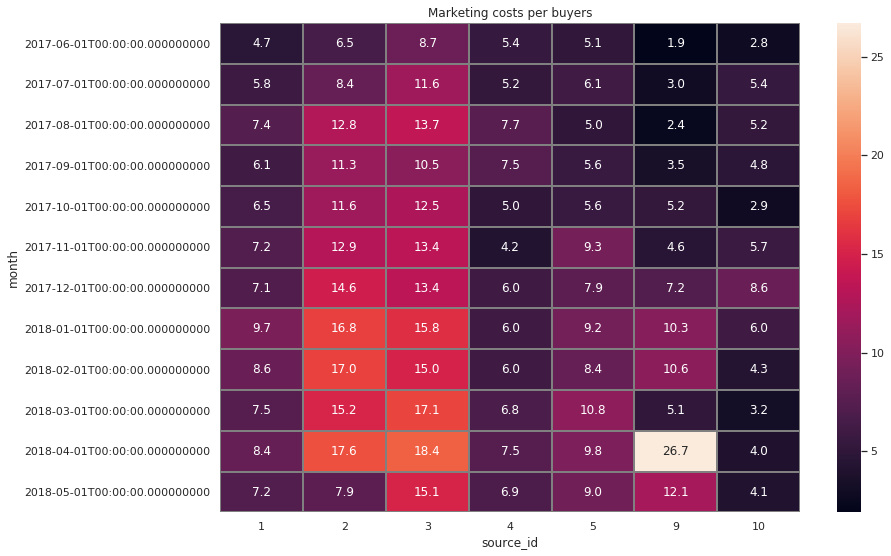

In [83]:
marketing_costs['costs_per_buyer'] = marketing_costs['costs'] / marketing_costs['buyers_n']
marketing_costs_report = marketing_costs.pivot_table(index='month',columns='source_id',values='costs_per_buyer',aggfunc='sum').round(1)
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Marketing costs per buyers')
sns.heatmap(marketing_costs_report, annot=True, fmt='.3', linewidths=1, linecolor='gray')

Сезонность есть, но она не носит ярко выраженного характера.  
Имеет смысл посмотреть на стоимость привлечения покупателя в целом, за весь исследуемый год.

In [84]:
marketing_costs_report_year = marketing_costs.pivot_table(index='source_id',
                                                          values=['buyers_n','costs'],
                                                          aggfunc={'buyers_n':'sum','costs':'sum'})
marketing_costs_report_year['costs_per_buyer'] = marketing_costs_report_year['costs'] / marketing_costs_report_year['buyers_n']
marketing_costs_report_year.reset_index()

,source_id,buyers_n,costs,costs_per_buyer
0,1,2920,20833.27,7.134682
1,2,3497,42806.04,12.240789
2,3,10464,141321.63,13.505507
3,4,10280,61073.60,5.941012
4,5,6960,51757.10,7.436365
5,9,1074,5517.49,5.137328
6,10,1327,5822.49,4.387709


Источники 2 и 3 заметно дороже, а дешевле всего обходятся покупатели, привлекаемые с помощью источников 9,10 и 4.

Добавим в этот датафрейм столбец с информацией о выручке за 6 месяцев "жизни" клиентов, привлеченных с помощью каждого источника.

In [85]:
marketing_costs_report_year = marketing_costs_report_year.merge(LTV_sources, on='source_id')
marketing_costs_report_year

,source_id,buyers_n,costs,costs_per_buyer,six_months
0,1,2920,20833.27,7.134682,8.55
1,2,3497,42806.04,12.240789,12.04
2,3,10464,141321.63,13.505507,5.10
3,4,10280,61073.60,5.941012,4.94
4,5,6960,51757.10,7.436365,7.40
5,9,1074,5517.49,5.137328,4.69
6,10,1327,5822.49,4.387709,3.53


Можем теперь посчитать совокупную отдачу по источникам (ROI).

In [86]:
marketing_costs_report_year['ROI'] = marketing_costs_report_year['six_months'] / marketing_costs_report_year['costs_per_buyer']
marketing_costs_report_year

,source_id,buyers_n,costs,costs_per_buyer,six_months,ROI
0,1,2920,20833.27,7.134682,8.55,1.198372
1,2,3497,42806.04,12.240789,12.04,0.983597
2,3,10464,141321.63,13.505507,5.10,0.377624
3,4,10280,61073.60,5.941012,4.94,0.831508
4,5,6960,51757.10,7.436365,7.40,0.995110
5,9,1074,5517.49,5.137328,4.69,0.912926
6,10,1327,5822.49,4.387709,3.53,0.804520


Видно, что источник 1 очень хорошо окупается, в то время как на источник 3 деньги тратятся впустую.

Изучим, наконец, срок окупаемости затрат на маркетинг в целом, без разбивки по источникам.  
Посчитаем CAC каждой когорты. Сначала найдём суммарные расходы за каждый месяц, а затем поделим их на количество покупателей в каждой когорте.

In [87]:
monthly_costs = costs.groupby('month')['costs'].sum().reset_index()
monthly_costs

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


Добавим данные о расходах в отчёт о когортах покупателей и посчитаем CAC.  

In [88]:
report_cohort_buyers_new = pd.merge(report_cohort_buyers, monthly_costs, left_on='first_activity_month', right_on='month')
report_cohort_buyers_new['cac'] = report_cohort_buyers_new['costs'] / report_cohort_buyers_new['n_buyers']
report_cohort_buyers_new.head()

,first_activity_month,n_buyers,visit_month,revenue,age,ltv,month,costs,cac
0,2017-06-01,2923,2017-06-01,9557.49,0,3.269754,2017-06-01,18015.0,6.163189
1,2017-06-01,2923,2017-07-01,2664.58,1,0.911591,2017-06-01,18015.0,6.163189
2,2017-06-01,2923,2017-08-01,1464.69,2,0.501091,2017-06-01,18015.0,6.163189
3,2017-06-01,2923,2017-09-01,3882.09,3,1.328118,2017-06-01,18015.0,6.163189
4,2017-06-01,2923,2017-10-01,3940.59,4,1.348132,2017-06-01,18015.0,6.163189


Рассчитаем ROMI: поделим LTV на CAC.
Чтобы посчитать накопительный ROMI, вызовем метод cumsum()

In [89]:
report_cohort_buyers_new['romi'] = report_cohort_buyers_new['ltv'] / report_cohort_buyers_new['cac']
output = report_cohort_buyers_new.pivot_table(
        index='first_activity_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

output.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,0.53,0.68,0.76,0.98,1.19,1.35,1.54,1.67,1.80,1.99,2.11,2.22
2017-07-01,0.54,0.60,0.66,0.71,0.76,0.80,0.84,0.88,0.92,0.95,0.98,NaN
2017-08-01,0.42,0.49,0.56,0.62,0.68,0.71,0.74,0.83,0.88,0.91,NaN,NaN
2017-09-01,0.51,0.66,0.75,1.17,1.23,1.31,1.34,1.37,1.38,NaN,NaN,NaN
2017-10-01,0.51,0.61,0.65,0.68,0.70,0.73,0.75,0.77,NaN,NaN,NaN,NaN
2017-11-01,0.44,0.51,0.54,0.58,0.61,0.63,0.64,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.44,0.49,0.59,0.73,0.77,0.81,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.32,0.37,0.41,0.42,0.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.35,0.41,0.43,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Окупаемости достигли первая и четвертая когорты, первая на пятый месяц, четвертая на четвертый.

Посчитаем среднюю когорту.

In [90]:
output.cumsum(axis=1).mean(axis=0)

age
0     0.439380
1     0.516865
2     0.580057
3     0.705022
4     0.796188
5     0.906254
6     0.977248
7     1.101976
8     1.246164
9     1.284510
10    1.545658
11    2.221818
dtype: float64

Можно ожидать, что в районе 8 месяца расходы на маркетинг по привлечению новых покупателей на Яндекс.Афишу окупятся.

### Основные выводы

1. Видно, что к Яндекс.Афише чаще обращаются в холодное время года: летом люди либо уезжают в отпуска, либо больше проводят времени на природе.  
2. Среднемесячное число уникальных пользователей - более 23 тысяч,  а еженедельно на портал заходят около 5700 человек.  
3. В среднем, один пользователь заходит на сайт один раз в день.  
4. При этом в районе 70-75% всех сессий приходится на стационарные компьютеры, с мобильных устройств заходят только около четверти посетителей.  
5. Средняя длина сессии - около 5 минут, при этом визиты со компьютеров длятся в 2 раза дольше, чем со смартфонов или планшетов (6 минут против 3).  
6. Уровень повторных визитов не очень велик: менее 10% посетителей приходят на сайт в следующем месяце после первого визита.  
7. Чаще всего покупка совершается при первом визите: мы не наблюдаем длинной предварительной истории посещений у покупателей.  
8. Доля покупателей от посетителей в районе 15% в среднем.  
9. Средний чек колеблется от 4 до 6 рублей (по всей видимости, комиссия Яндекс.Афиши при покупках билетов).  
10. Средний покупатель делает 1,2 заказа в месяц.  
11. Если взять срок жизни покупателя за один год, средний покупатель приносит 12 рублей.  
12. Затраты на маркетинг колеблются от 18 тысяч в июне 2017 года до более 28 тысяч в декабре 2018. Наиболее высокие расходы фиксируются с октября по март.  
13. Наибольшие расходы приходятся на третий источник, за которым следуют четвертый, второй и пятый.  
14. В пересчете на одного покупателя дороже всего стоят источники 2 и 3, а дешевле - 9, 10 и 4.  
15. Имеет смысл сократить расходы на источник 3: он дорого обходится с точки зрения привлечения новых покупателей, но эти покупатели себя не окупают.  
16. Источник 2 хоть и достаточно дорог, приносит прибыльных покупателей.  
17. Имеет смысл подумать над увеличением расходов на источник 1: этот источник относительно недорог и приносит платежеспособных клиентов.  
18. В целом, можно ожидать, что расходы на привлечение новых покупателей на Яндекс.Афишу окупаются в районе 8 месяца.